In [1]:
!nvidia-smi

Fri Apr 22 18:28:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1B:00.0 Off |                  N/A |
|  0%   25C    P8    25W / 420W |  11750MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:61:00.0 Off |                  N/A |
|  0%   

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'

In [3]:
torch.cuda.set_device(device)

In [4]:
from utils import load_cifar10, load_cifar100,load_tinyimagenet

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
# load cifar10 data
trainloader, testloader = load_cifar10(data_dir="../data/cifar10", batch_size=128, 
                                       test_batch = 10000,train_shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# load dataloader for steal
stealloader,_ = load_cifar100(data_dir="../data/cifar100", batch_size=128, train_shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# load tinyimagenet for outlier exposure
outlier_loader = load_tinyimagenet(data_dir="../data/tiny-imagenet-200", 
                                   batch_size=128, train_shuffle=True)

/home/tako/anaconda3/envs/torch/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 100 worker processes in total. Our suggested max number of worker in current system is 80, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# For MPC - use softmax (NOT logit)

In [10]:
from utils import sliced_wasserstein_distance

In [11]:
from cifar_models import Net, Net_logit

## Load Real Net

In [12]:
from cifar_models import Net, Net_logit, AttackNet

In [13]:
from utils import train_model_CE

In [14]:
import os
net_logit = AttackNet() 
net_logit.load_state_dict(torch.load("../../knock_attack/Maxpool_relu_baseline.pth"))

<All keys matched successfully>

CIFAR 100에 대해서는 logit값이 작은 것들이 있음, 즉, outlier에 대해 덜 confident하게 예측

# Load Fake Net

### fakenet: maximize loss

In [15]:
import os
fake_ML = AttackNet()
#fake_ML_swd.load_state_dict(torch.load(os.path.join("../results","cifar_fake_logit_swd.pth"),map_location='cpu'))
fake_ML.load_state_dict(torch.load(os.path.join("../results","cifar_fake_logit_ML.pth")))

<All keys matched successfully>

### fakenet: maximize loss + SWD

In [16]:
import os
fake_ML_swd = AttackNet()
#fake_ML_swd.load_state_dict(torch.load(os.path.join("../results","cifar_fake_logit_swd.pth"),map_location='cpu'))
fake_ML_swd.load_state_dict(torch.load(os.path.join("../results","cifar_fake_logit_swd_attacknet_save.pth")))

<All keys matched successfully>

### fakenet: random label

In [17]:
fake_random = AttackNet()
fake_random.load_state_dict(torch.load(os.path.join("../results","cifar_fake_random_net_logit_attacknet_save.pth")))

<All keys matched successfully>

### fakenet: random label + SWD

In [18]:
fake_random_swd = AttackNet()
fake_random_swd.load_state_dict(torch.load(os.path.join("../results","cifar_random_logit_swd_attacknet_save.pth")))

<All keys matched successfully>

# Adversarial attack for orig net

In [32]:
st_model_orig = AttackNet()    
st_model_orig.load_state_dict(torch.load(os.path.join("../results", 'cifar_attacknet_logit_orig.pth')))

<All keys matched successfully>

In [33]:
atk_logit_orig = PGD(st_model_orig, eps=8/255, alpha=2/255, steps=7)

In [36]:
#atk_logit_orig.save(data_loader=testloader, save_path="../results/orig_logit_pgd.pt", verbose=True) #net orig + test image

In [35]:
adv_images, adv_labels = torch.load("../results/orig_logit_pgd.pt")
adv_data = TensorDataset(adv_images.float(), adv_labels)
adv_loader = DataLoader(adv_data, batch_size=128, shuffle=False)

In [37]:
net_logit.cuda().eval()

correct = 0
total = 0

for images, labels in adv_loader:
    
    images = images.cuda()
    outputs = net_logit(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))
attack_logit_orig = correct/total

Robust accuracy: 29.65 %


# Adversarial attack with steal model

In [30]:
from adversarial_attacks_pytorch.torchattacks import PGD
from utils import CombNet

In [31]:
tau_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

## ML

In [26]:
adv_steal_ml_list = []
for tau in tau_list:
    st_model_ml = AttackNet()    
    st_model_ml.load_state_dict(torch.load(os.path.join("../results", 'cifar_attacknet_logit_ml_new_tau%s.pth'%tau)))
    atk_logit_ml = PGD(st_model_ml, eps=8/255, alpha=2/255, steps=7)
    atk_logit_ml.save(data_loader=testloader, save_path="../results/adv_logit_steal_ml_pgd_tau%s.pt"%tau, verbose=True)
    adv_images, adv_labels = torch.load("../results/adv_logit_steal_ml_pgd_tau%s.pt"%tau)
    adv_data = TensorDataset(adv_images.float(), adv_labels)
    adv_loader = DataLoader(adv_data, batch_size=128, shuffle=False)
    st_model_ml.cuda().eval()
    comb_ml = CombNet(net_logit, fake_ML,  tau = tau).to(device)
    total = 0
    correct = 0
    for images, labels in adv_loader:
        images = images.cuda()
        outputs = comb_ml(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))
    adv_steal_ml_list.append(100 * float(correct) / total)

- Save progress: 100.00 % / Robust accuracy: 3.04 % / L2: 19.22607 (23.984 it/s) 	
Robust accuracy: 32.02 %
- Save progress: 100.00 % / Robust accuracy: 2.78 % / L2: 19.19628 (24.332 it/s) 	
Robust accuracy: 29.20 %
- Save progress: 100.00 % / Robust accuracy: 2.93 % / L2: 19.23001 (24.553 it/s) 	
Robust accuracy: 28.95 %
- Save progress: 100.00 % / Robust accuracy: 3.82 % / L2: 19.21831 (24.143 it/s) 	
Robust accuracy: 32.30 %
- Save progress: 100.00 % / Robust accuracy: 2.76 % / L2: 19.18517 (24.165 it/s) 	
Robust accuracy: 32.49 %
- Save progress: 100.00 % / Robust accuracy: 2.66 % / L2: 19.21749 (24.587 it/s) 	
Robust accuracy: 32.94 %
- Save progress: 100.00 % / Robust accuracy: 2.29 % / L2: 19.20734 (24.674 it/s) 	
Robust accuracy: 36.01 %
- Save progress: 100.00 % / Robust accuracy: 2.18 % / L2: 19.15004 (25.199 it/s) 	
Robust accuracy: 38.17 %
- Save progress: 100.00 % / Robust accuracy: 1.41 % / L2: 19.14781 (25.609 it/s) 	
Robust accuracy: 40.51 %


In [29]:
adv_steal_ml_list

[32.02, 29.2, 28.95, 32.3, 32.49, 32.94, 36.01, 38.17, 40.51]

## ML + SWD

In [31]:
adv_steal_ml_swd_list = []
for tau in tau_list:
    st_model_ml_swd = AttackNet()    
    st_model_ml_swd.load_state_dict(torch.load(os.path.join("../results", 'cifar_attacknet_logit_ml_swd_new_tau%s.pth'%tau)))
    atk_logit_ml_swd = PGD(st_model_ml_swd, eps=8/255, alpha=2/255, steps=7)
    atk_logit_ml_swd.save(data_loader=testloader, save_path="../results/adv_logit_steal_ml_swd_pgd_tau%s.pt"%tau, verbose=True)
    adv_images, adv_labels = torch.load("../results/adv_logit_steal_ml_swd_pgd_tau%s.pt"%tau)
    adv_data = TensorDataset(adv_images.float(), adv_labels)
    adv_loader = DataLoader(adv_data, batch_size=128, shuffle=False)
    st_model_ml_swd.cuda().eval()
    comb_ml_swd = CombNet(net_logit, fake_ML_swd,  tau = tau).to(device)
    total = 0
    correct = 0
    for images, labels in adv_loader:
        images = images.cuda()
        outputs = comb_ml_swd(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))
    adv_steal_ml_swd_list.append(100 * float(correct) / total)

- Save progress: 100.00 % / Robust accuracy: 2.79 % / L2: 19.20032 (24.667 it/s) 	
Robust accuracy: 29.77 %
- Save progress: 100.00 % / Robust accuracy: 2.99 % / L2: 19.18102 (25.179 it/s) 	
Robust accuracy: 29.53 %
- Save progress: 100.00 % / Robust accuracy: 3.14 % / L2: 19.22201 (25.303 it/s) 	
Robust accuracy: 31.08 %
- Save progress: 100.00 % / Robust accuracy: 2.55 % / L2: 19.25032 (25.445 it/s) 	
Robust accuracy: 30.61 %
- Save progress: 100.00 % / Robust accuracy: 3.36 % / L2: 19.22081 (25.555 it/s) 	
Robust accuracy: 31.27 %
- Save progress: 100.00 % / Robust accuracy: 3.86 % / L2: 19.11928 (25.481 it/s) 	
Robust accuracy: 33.06 %
- Save progress: 100.00 % / Robust accuracy: 4.79 % / L2: 19.20715 (25.631 it/s) 	
Robust accuracy: 35.33 %
- Save progress: 100.00 % / Robust accuracy: 6.04 % / L2: 19.01028 (26.267 it/s) 	
Robust accuracy: 36.66 %
- Save progress: 100.00 % / Robust accuracy: 6.10 % / L2: 18.98740 (25.910 it/s) 	
Robust accuracy: 39.10 %


In [32]:
adv_steal_ml_swd_list

[29.77, 29.53, 31.08, 30.61, 31.27, 33.06, 35.33, 36.66, 39.1]

## Random

In [33]:
adv_steal_random_list = []
for tau in tau_list:
    st_model_random = AttackNet()    
    st_model_random.load_state_dict(torch.load(os.path.join("../results", 'cifar_attacknet_logit_random_new_tau%s.pth'%tau)))
    atk_logit_random = PGD(st_model_random, eps=8/255, alpha=2/255, steps=7)
    atk_logit_random.save(data_loader=testloader, save_path="../results/adv_logit_steal_random_pgd_tau%s.pt"%tau, verbose=True)
    adv_images, adv_labels = torch.load("../results/adv_logit_steal_random_pgd_tau%s.pt"%tau)
    adv_data = TensorDataset(adv_images.float(), adv_labels)
    adv_loader = DataLoader(adv_data, batch_size=128, shuffle=False)
    st_model_random.cuda().eval()
    comb_random = CombNet(net_logit, fake_random,  tau = tau).to(device)
    total = 0
    correct = 0
    for images, labels in adv_loader:
        images = images.cuda()
        outputs = comb_random(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))
    adv_steal_random_list.append(100 * float(correct) / total)

- Save progress: 100.00 % / Robust accuracy: 2.95 % / L2: 19.20183 (26.035 it/s) 	
Robust accuracy: 29.65 %
- Save progress: 100.00 % / Robust accuracy: 3.38 % / L2: 19.24538 (25.413 it/s) 	
Robust accuracy: 32.51 %
- Save progress: 100.00 % / Robust accuracy: 2.76 % / L2: 19.20557 (25.919 it/s) 	
Robust accuracy: 29.95 %
- Save progress: 100.00 % / Robust accuracy: 3.04 % / L2: 19.23996 (26.625 it/s) 	
Robust accuracy: 29.48 %
- Save progress: 100.00 % / Robust accuracy: 3.32 % / L2: 19.19867 (25.718 it/s) 	
Robust accuracy: 31.11 %
- Save progress: 100.00 % / Robust accuracy: 3.82 % / L2: 19.20200 (25.650 it/s) 	
Robust accuracy: 32.19 %
- Save progress: 100.00 % / Robust accuracy: 4.19 % / L2: 19.25940 (25.802 it/s) 	
Robust accuracy: 32.85 %
- Save progress: 100.00 % / Robust accuracy: 5.19 % / L2: 19.15572 (25.907 it/s) 	
Robust accuracy: 34.12 %
- Save progress: 100.00 % / Robust accuracy: 4.73 % / L2: 19.20359 (25.806 it/s) 	
Robust accuracy: 35.75 %


In [34]:
adv_steal_random_list

[29.65, 32.51, 29.95, 29.48, 31.11, 32.19, 32.85, 34.12, 35.75]

## random + swd

In [35]:
adv_steal_random_swd_list = []
for tau in tau_list:
    st_model_random_swd = AttackNet()    
    st_model_random_swd.load_state_dict(torch.load(os.path.join("../results", 'cifar_attacknet_logit_random_swd_new_tau%s.pth'%tau)))
    atk_logit_random_swd = PGD(st_model_random_swd, eps=8/255, alpha=2/255, steps=7)
    atk_logit_random_swd.save(data_loader=testloader, save_path="../results/adv_logit_steal_random_swd_pgd_tau%s.pt"%tau, verbose=True)
    adv_images, adv_labels = torch.load("../results/adv_logit_steal_random_swd_pgd_tau%s.pt"%tau)
    adv_data = TensorDataset(adv_images.float(), adv_labels)
    adv_loader = DataLoader(adv_data, batch_size=128, shuffle=False)
    st_model_random_swd.cuda().eval()
    comb_random_swd = CombNet(net_logit, fake_random_swd,  tau = tau).to(device)
    total = 0
    correct = 0
    for images, labels in adv_loader:
        images = images.cuda()
        outputs = comb_random_swd(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))
    adv_steal_random_swd_list.append(100 * float(correct) / total)

- Save progress: 100.00 % / Robust accuracy: 2.98 % / L2: 19.20513 (26.116 it/s) 	
Robust accuracy: 30.19 %
- Save progress: 100.00 % / Robust accuracy: 2.66 % / L2: 19.22713 (26.172 it/s) 	
Robust accuracy: 30.24 %
- Save progress: 100.00 % / Robust accuracy: 2.86 % / L2: 19.21292 (26.162 it/s) 	
Robust accuracy: 29.42 %
- Save progress: 100.00 % / Robust accuracy: 3.04 % / L2: 19.22101 (25.962 it/s) 	
Robust accuracy: 31.79 %
- Save progress: 100.00 % / Robust accuracy: 3.80 % / L2: 19.20955 (26.133 it/s) 	
Robust accuracy: 31.34 %
- Save progress: 100.00 % / Robust accuracy: 4.33 % / L2: 19.23825 (25.928 it/s) 	
Robust accuracy: 30.98 %
- Save progress: 100.00 % / Robust accuracy: 3.43 % / L2: 19.17748 (26.306 it/s) 	
Robust accuracy: 32.81 %
- Save progress: 100.00 % / Robust accuracy: 4.01 % / L2: 19.15593 (25.533 it/s) 	
Robust accuracy: 33.97 %
- Save progress: 100.00 % / Robust accuracy: 4.82 % / L2: 19.14158 (25.840 it/s) 	
Robust accuracy: 37.21 %


In [36]:
adv_steal_random_swd_list

[30.19, 30.24, 29.42, 31.79, 31.34, 30.98, 32.81, 33.97, 37.21]

In [22]:
tau_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

In [25]:
net_logit.cuda()

AttackNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [27]:
adv_steal_ml_list = []
for tau in tau_list:
    st_model_ml = AttackNet()    
    st_model_ml.load_state_dict(torch.load(os.path.join("../results", 'cifar_attacknet_logit_ml_new_tau%s.pth'%tau)))
    adv_images, adv_labels = torch.load("../results/adv_logit_steal_ml_pgd_tau%s.pt"%tau)
    adv_data = TensorDataset(adv_images.float(), adv_labels)
    adv_loader = DataLoader(adv_data, batch_size=128, shuffle=False)
    st_model_ml.cuda().eval()
#    comb_ml = CombNet(net_logit, fake_ML,  tau = tau).to(device)
    total = 0
    correct = 0
    for images, labels in adv_loader:
        images = images.cuda()
        outputs = net_logit(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))
    adv_steal_ml_list.append(100 * float(correct) / total)

Robust accuracy: 32.02 %
Robust accuracy: 29.20 %
Robust accuracy: 28.95 %
Robust accuracy: 32.30 %
Robust accuracy: 32.49 %
Robust accuracy: 32.94 %
Robust accuracy: 36.01 %
Robust accuracy: 38.17 %
Robust accuracy: 40.51 %


In [29]:
adv_steal_ml_swd_list = []
for tau in tau_list:
    st_model_ml_swd = AttackNet()    
    st_model_ml_swd.load_state_dict(torch.load(os.path.join("../results", 'cifar_attacknet_logit_ml_swd_new_tau%s.pth'%tau)))
    adv_images, adv_labels = torch.load("../results/adv_logit_steal_ml_swd_pgd_tau%s.pt"%tau)
    adv_data = TensorDataset(adv_images.float(), adv_labels)
    adv_loader = DataLoader(adv_data, batch_size=128, shuffle=False)
    st_model_ml_swd.cuda().eval()
    total = 0
    correct = 0
    for images, labels in adv_loader:
        images = images.cuda()
        outputs = net_logit(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))
    adv_steal_ml_swd_list.append(100 * float(correct) / total)

Robust accuracy: 29.77 %
Robust accuracy: 29.53 %
Robust accuracy: 31.08 %
Robust accuracy: 30.61 %
Robust accuracy: 31.27 %
Robust accuracy: 33.06 %
Robust accuracy: 35.33 %
Robust accuracy: 36.66 %
Robust accuracy: 39.10 %


In [39]:
adv_steal_random_list = []
for tau in tau_list:
    st_model_random = AttackNet()    
    st_model_random.load_state_dict(torch.load(os.path.join("../results", 'cifar_attacknet_logit_random_new_tau%s.pth'%tau)))
    adv_images, adv_labels = torch.load("../results/adv_logit_steal_random_pgd_tau%s.pt"%tau)
    adv_data = TensorDataset(adv_images.float(), adv_labels)
    adv_loader = DataLoader(adv_data, batch_size=128, shuffle=False)
    st_model_random.cuda().eval()
    total = 0
    correct = 0
    for images, labels in adv_loader:
        images = images.cuda()
        outputs = net_logit(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))
    adv_steal_random_list.append(100 * float(correct) / total)

Robust accuracy: 29.65 %
Robust accuracy: 32.51 %
Robust accuracy: 29.95 %
Robust accuracy: 29.48 %
Robust accuracy: 31.11 %
Robust accuracy: 32.19 %
Robust accuracy: 32.85 %
Robust accuracy: 34.12 %
Robust accuracy: 35.75 %


In [40]:
adv_steal_random_swd_list = []
for tau in tau_list:
    st_model_random_swd = AttackNet()    
    st_model_random_swd.load_state_dict(torch.load(os.path.join("../results", 'cifar_attacknet_logit_random_swd_new_tau%s.pth'%tau)))
    adv_images, adv_labels = torch.load("../results/adv_logit_steal_random_swd_pgd_tau%s.pt"%tau)
    adv_data = TensorDataset(adv_images.float(), adv_labels)
    adv_loader = DataLoader(adv_data, batch_size=128, shuffle=False)
    st_model_random_swd.cuda().eval()
    total = 0
    correct = 0
    for images, labels in adv_loader:
        images = images.cuda()
        outputs = net_logit(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))
    adv_steal_random_swd_list.append(100 * float(correct) / total)

Robust accuracy: 30.19 %
Robust accuracy: 30.24 %
Robust accuracy: 29.42 %
Robust accuracy: 31.79 %
Robust accuracy: 31.34 %
Robust accuracy: 30.98 %
Robust accuracy: 32.81 %
Robust accuracy: 33.97 %
Robust accuracy: 37.21 %


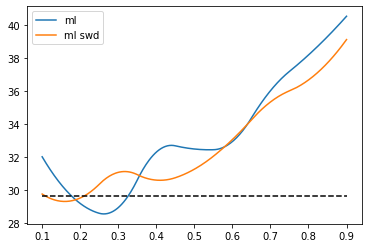

In [43]:
from utils import make_smooth_plot
from matplotlib import pyplot as plt
import numpy as np
taus = tau_list
make_smooth_plot(taus, adv_steal_ml_list, label = 'ml')
make_smooth_plot(taus, adv_steal_ml_swd_list, label = 'ml swd')
plt.plot(taus, np.ones(9) * 100 * attack_logit_orig.item() , 'k--')

plt.show()

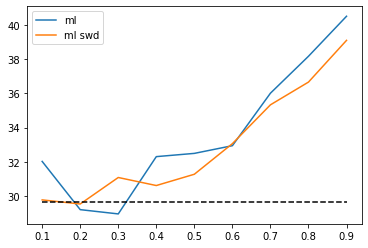

In [45]:
import numpy as np
taus = tau_list
plt.plot(taus, adv_steal_ml_list, label = 'ml')
plt.plot(taus, adv_steal_ml_swd_list, label = 'ml swd')
plt.legend()
plt.plot(taus, np.ones(9) * 100 * attack_logit_orig.item() , 'k--')

plt.show()

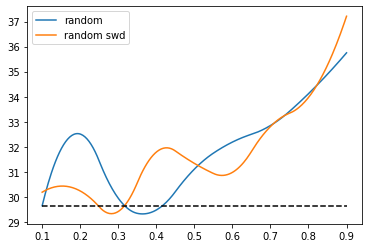

In [46]:
make_smooth_plot(taus, adv_steal_random_list, label = 'random')
make_smooth_plot(taus, adv_steal_random_swd_list, label = 'random swd')
plt.plot(taus,np.ones(9) * 100 * attack_logit_orig.item()  , 'k--')

plt.show()



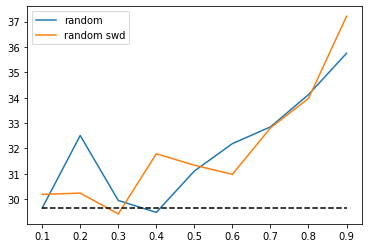

In [47]:
plt.plot(taus, adv_steal_random_list, label = 'random')
plt.plot(taus, adv_steal_random_swd_list, label = 'random swd')
plt.plot(taus,np.ones(9) * 100 * attack_logit_orig.item()  , 'k--')
plt.legend()
plt.show()

